In [1]:
import dolfinx as dlx
import numpy as np
import pyvista as pv
from mpi4py import MPI

from ls_prior import builder

pv.global_theme.jupyter_backend = "static"

In [2]:
mpi_communicator = MPI.COMM_WORLD
mesh, *_ = dlx.io.gmshio.read_from_msh("left_atrium_surface.msh", mpi_communicator, rank=0, gdim=3)
num_vertices = mesh.geometry.x.shape[0]
mean_vector = np.zeros(num_vertices)

Info    : Reading 'left_atrium_surface.msh'...
Info    : 1 entity
Info    : 8843 nodes
Info    : 17444 elements
Info    : Done reading 'left_atrium_surface.msh'


In [3]:
prior_settings = builder.BilaplacianPriorSettings(
    mesh=mesh,
    mean_vector=mean_vector,
    kappa=0.5,
    tau=1,
    seed=42,
)
prior_builder = builder.BilaplacianPriorBuilder(prior_settings)
bilaplace_prior = prior_builder.build()

In [4]:
test_vector_1 = np.ones_like(mean_vector)
test_vector_2 = 2 * np.ones_like(mean_vector)
test_vector_3 = 3 * np.ones_like(mean_vector)

cost = bilaplace_prior.evaluate_cost(test_vector_1)
grad = bilaplace_prior.evaluate_gradient(test_vector_2)
hvp = bilaplace_prior.evaluate_hessian_vector_product(test_vector_3)
sample = bilaplace_prior.generate_sample()

print(cost)
print(grad)
print(hvp)
print(sample)

272.1929235670469
[0.10560344 0.05883214 0.06777718 ... 0.09306523 0.13613879 0.11233247]
[0.15840516 0.08824821 0.10166577 ... 0.13959785 0.20420819 0.1684987 ]
[-0.10351894 -0.4361511   0.08617151 ... -0.2717732  -0.63439647
 -0.3125484 ]


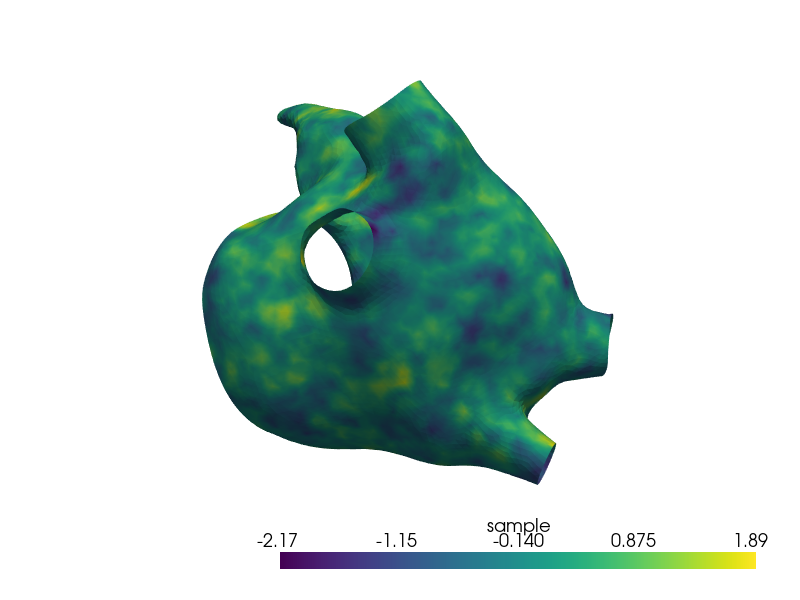

In [5]:
vertices = mesh.geometry.x
simplices = mesh.geometry.dofmap

camera_position = [
    (92.7033800655023, -107.54971248826202, -146.9233989237418),
    (5.789453506469723, -8.405534744262697, 10.9196138381958),
    (0.64544246900107, 0.7545534378669008, -0.11854589243429736),
]
pv_mesh = pv.PolyData.from_regular_faces(vertices, simplices)
pv_mesh.point_data["sample"] = sample
plotter = pv.Plotter()
plotter.add_mesh(pv_mesh, scalars="sample", cmap="viridis", show_edges=False, show_scalar_bar=True)
plotter.show(window_size=[800, 600], cpos=camera_position)